# Part 1: Network Training

## Step0: Import Package & Hyperparameter Configuration

In [37]:
"""
2025/02/03: 1.新增normDict計算 #!注意normDict是有先經過資料前處理計算的
            2.資料集中任意取n筆去訓練(n:自填數) 
            
2025/03/17: 1.修改增加Hdc,N輸入參數
            2.Mdoel修正兩個子迴路接考慮Hdc與N            
            
"""

'\n2025/02/03: 1.新增normDict計算 #!注意normDict是有先經過資料前處理計算的\n            2.資料集中任意取n筆去訓練(n:自填數) \n            \n2025/03/17: 1.修改增加Hdc,N輸入參數\n            2.Mdoel修正兩個子迴路接考慮Hdc與N            \n            \n'

In [38]:
%reset -f  # 清空所有變數

import gc
gc.collect()  # 強制 Python 回收記憶體


Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  清空所有變數, please run `%reset?` for details


0


### Package


In [39]:
import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

### Hyperparameter Config

In [40]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 3000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Material & Number of Data

In [41]:
material = "CH467160"
downsample = 128

# 定義保存模型的路徑
model_save_dir = "./Model/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑

# 定義模型保存檔名
model_save_path = os.path.join(model_save_dir, f"{material}.pt")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Data processing and data loader generate 

In [ ]:
# %% Preprocess data into a data loader
def get_dataloader(data_B,
                   data_F,
                   data_T,
                   data_H,
                   data_N,
                   data_Hdc,
                   data_Pcv,
                   n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_N : np.array
        Turns data.
    data_Hdc : np.array
        DC Magnetic field strength data.
    data_H : np.array
        AC Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
        train_loader, valid_loader : DataLoader
        Dataloaders for training, validation
        norm
    """

    # Data pre-process
    # 1. Down-sample to 128 points
    seq_length = downsample
    cols = range(
        0, 8192, int(8192 / seq_length)
    )  #range(start, stop, step) #*  Add  Down-sample: 8192 to 128 points (Date:241213)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    data_B = data_B - np.mean(data_B, axis=1,
                              keepdims=True)  #*  移除降階影響 (Date:250325)
    data_H = data_H - np.mean(data_H, axis=1, keepdims=True)

    # 2. Add extra points for initial magnetization calculation
    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack(
        (data_H, data_H[:, :n_init]))  #*(Date:241216) MMINN output似乎是128點
    #*(Date:250130) 原始MMINN H有包含n_init

    # 3. Format data into tensors  #*(Date:241216) seq_length=128, data_length=144
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Hdc = torch.from_numpy(data_Hdc).view(-1, 1).float()
    N = torch.from_numpy(data_N).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # 原本在6. 因要先計算標準化故移至這
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    # # 4. Compute normalization parameters (均值 & 標準差)**
    # norm = [
    #     [torch.mean(B).item(), torch.std(B).item()],  # B
    #     [torch.mean(H).item(), torch.std(H).item()],  # H
    #     [torch.mean(F).item(), torch.std(F).item()],  # F
    #     [torch.mean(T).item(), torch.std(T).item()],  # T
    #     [torch.mean(Hdc).item(), torch.std(Hdc).item()],  # Hdc #*(250317新加入)
    #     [torch.mean(N).item(), torch.std(N).item()],  # N #*(250317新加入)
    #     [torch.mean(Pcv).item(), torch.std(Pcv).item()],  # Pv
    # ]

    #  4. Compute normalization parameters (均值 & 標準差)**
    # ! 溫度頻率不變加入微小的 epsilon
    norm = [
        safe_mean_std(B),  # 0: B
        safe_mean_std(H),  # 1: H
        safe_mean_std(F),  # 2: F
        safe_mean_std(T),  # 3: T
        safe_mean_std(dB_dt),  # 4: dB/dt
        safe_mean_std(Pcv),  # 5: Pcv
        safe_mean_std(Hdc),  # 6: Hdc
        safe_mean_std(N)  # 7: N
    ]

    # 用來做test固定標準化參數的
    material_name = f"{material}"
    print(f'"{material_name}": [')
    for param in norm:
        print(f"    {param},")
    print("]")

    # 5. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]  # B
    out_H = (H - norm[1][0]) / norm[1][1]  # H
    in_F = (F - norm[2][0]) / norm[2][1]  # F
    in_T = (T - norm[3][0]) / norm[3][1]  # T

    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]  # Pcv
    in_Hdc = (Hdc - norm[6][0]) / norm[6][1]  # Hdc
    in_N = (N - norm[7][0]) / norm[7][1]  # N

    # 6. Extra features

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 7. Create dataloader to speed up data processing
    full_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_Hdc, in_N, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H)

    # Split dataset into train, validation, and test sets (60:20:20)
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size

    train_dataset, valid_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0,
                                               collate_fn=filter_input)

    return train_loader, valid_loader, norm


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(
        features
    )[:, :4]  #!(250317)保留 in_F, in_T, in_Hdc, in_N (排除 in_Pcv，in_Pcv要放在最面)

    # 保留目標值 H
    target_H = torch.stack(
        target_H)[:, -downsample:, :]  # ?只取最後 128 點 (改1024看狀況有無變好)

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0, target_H


# ! 溫度頻率不變加入微小的 epsilon
def safe_mean_std(tensor, eps=1e-8):
    m_tensor = torch.mean(tensor)  # 還是 Tensor
    s_tensor = torch.std(tensor)  # 還是 Tensor

    m_val = m_tensor.item()  # 第一次轉成 float
    s_val = s_tensor.item()
    if s_val < eps:
        s_val = 1.0

    return [m_val, s_val]  # 直接回傳 float


## Step2: Define Network Structure

In [43]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
# ! - var_size: number of supplenmentary variables (1.F 2.T 3.Hdc 4.N)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):
    def __init__(
            self,
            norm,  #*這裡改成從外部傳入 norm(250203)
            hidden_size=Config.HIDDEN_SIZE,
            operator_size=Config.OPERATOR_SIZE,
            input_size=3,
            var_size=4,
            output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = norm  #*這裡改成從外部傳入 norm(250203)

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 4,
                              1)  #!250317更新：operator_size + 4
        self.rnn2 = EddyCell(
            6, self.hidden_size,
            output_size)  #!250317更新：4 (F, T, B, dB/dt ) + 2 (Hdc, N)
        self.dnn2 = nn.Linear(self.hidden_size, 1)

        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
# !       - var(batch,var_size): Supplementary inputs (1.F 2.T 3.Hdc 4.N) 
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # Initialize DNN2 input (1.B 2.dB/dt)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T,Hdc,N)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, n_init:, :])

        return H


class StopOperatorCell():
    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden


In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Step3: Training the Model

### Load Dataset

In [45]:
# %%
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/train/B_Field.csv"
    in_file2 = f"{base_path}{material}/train/Frequency.csv"
    in_file3 = f"{base_path}{material}/train/Temperature.csv"
    in_file4 = f"{base_path}{material}/train/H_Field.csv"
    in_file5 = f"{base_path}{material}/train/Volumetric_Loss.csv"
    in_file6 = f"{base_path}{material}/train/Hdc.csv"  # *250317新增：直流偏置磁場
    in_file7 = f"{base_path}{material}/train/Turns.csv"  # *250317新增：匝數

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N x 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N x 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N x 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N x 1024  # *250317新增
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N x 1
    data_Hdc = np.genfromtxt(in_file6, delimiter=',')  # N x 1  # *250317新增
    data_N = np.genfromtxt(in_file7, delimiter=',')  # N x 1

    return data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N


### Train Code

In [46]:
# %%
def train_model(norm, train_loader, valid_loader):

    model = MMINet(norm=norm).to(device)
    print("Number of parameters: ", count_parameters(model))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    best_val_loss = float('inf')
    patience_counter = 0

    # 定義保存路徑
    model_save_path = os.path.join("./Model/", f"{material}.pt")

    # **新增 Loss 記錄**
    train_losses = []
    val_losses = []

    for epoch in range(Config.NUM_EPOCHS):
        model.train()
        train_loss = 0

        for inputs, features, s0, target_H in train_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, features, s0)  # 模型的輸出
            loss = criterion(outputs, target_H)  # 使用真實的 H(t) 計算損失
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # **記錄 Train Loss**

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for inputs, features, s0, target_H in valid_loader:
                inputs, features, s0, target_H = inputs.to(
                    device), features.to(device), s0.to(device), target_H.to(
                        device)
                outputs = model(inputs, features, s0)
                loss = criterion(outputs, target_H)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        val_losses.append(val_loss)  # **記錄 Validation Loss**

        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}"
        )

        # ======================================================繪製訓練情況======================================================
        plot_interval = 500
        if (epoch + 1) % plot_interval == 0:
            outputs = outputs[:6].detach().cpu().numpy()
            targets = target_H[:6].detach().cpu().numpy()

            # 設定圖表
            plt.figure(figsize=(12, 6))

            for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
                plt.plot(outputs[i, :, 0],
                         label=f"Pred: Sample {i+1}",
                         linestyle='--',
                         marker='o')
                plt.plot(targets[i, :, 0],
                         label=f"Target: Sample {i+1}",
                         linestyle='-',
                         marker='x')

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            plt.xlabel("Index", fontsize=14)
            plt.ylabel("Value", fontsize=14)
            plt.legend(loc="upper right", fontsize=12)
            plt.grid(alpha=0.5)

            # 顯示圖表
            plt.show()
        # ======================================================繪製訓練情況= END ======================================================

        # ======================================================Early stop======================================================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
            print(
                f"Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
            )
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

        # ======================================================Early stop======================================================

    print(f"Training complete. Best model saved at {model_save_path}.")

    # ==============================繪製 Train Loss 與 Validation Loss 圖==============================
    plt.figure(figsize=(10, 5))
    plt.plot(
        range(1,
              len(train_losses) + 1),
        train_losses,
        label="Train Loss",
    )
    plt.plot(range(1,
                   len(val_losses) + 1),
             val_losses,
             label="Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()
    # ==============================繪製 Train Loss 與 Validation Loss 圖 END==============================

    # ===================================使用最佳模型來產生驗證結果=============================
    model.load_state_dict(torch.load(model_save_path))  # 載入最佳模型
    model.eval()

    with torch.no_grad():
        for inputs, features, s0, target_H in valid_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            outputs = model(inputs, features, s0)  # 使用最佳模型產生預測值
            outputs = outputs[:10].detach().cpu().numpy()
            targets = target_H[:10].detach().cpu().numpy()
            break  # 只使用一批驗證數據進行可視化

    # **繪製最佳模型的輸出與 Ground Truth 比較**
    plt.figure(figsize=(12, 6))

    for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
        plt.plot(outputs[i, :, 0],
                 label=f"Pred: Sample {i+1}",
                 linestyle='--',
                 marker='o')
        plt.plot(targets[i, :, 0],
                 label=f"Target: Sample {i+1}",
                 linestyle='-',
                 marker='x')

    plt.title(f"Best Model - Predicted vs Target", fontsize=16)
    plt.xlabel("Index", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

    # ===================================使用最佳模型來產生驗證結果 END=============================

In [47]:
# 驗證輸入shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     print(f"inputs shape: {inputs.shape}")  # 包括 in_B, in_dB, in_dB_dt
#     print(f"features shape: {features.shape}")  # 包括 in_F, in_T
#     print(f"s0 shape: {s0.shape}")  # 初始化狀態向量
#     break

# 驗證輸出shape
# net = MMINet(Material=material).to(device)
# for inputs, features, s0 in train_loader:
#     # 提取輸入數據
#     inputs = inputs.to(device)  # in_B, in_dB, in_dB_dt
#     features = features.to(device)  # in_F, in_T
#     s0 = s0.to(device)  # 初始狀態向量

#     # 將數據傳入模型
#     outputs = net(inputs, features, s0)

#     # 打印輸出形狀與樣本數據
#     print(f"outputs shape: {outputs.shape}")
#     print(f"outputs data: {outputs[0]}")  # 打印第一個樣本的輸出波形數據
#     break


### Start Train!!!

"CH467160": [
    [0.0012312656035646796, 0.028775393962860107],
    [7.502666473388672, 158.26292419433594],
    [2.0, 1.0],
    [25.0, 1.0],
    [0.045043062418699265, 0.45703446865081787],
    [1.8202824592590332, 0.7588016986846924],
    [1190.1402587890625, 703.06787109375],
    [10.274093627929688, 1.1386340856552124],
]
Number of parameters:  1146
Epoch 1, Train Loss: 1.082926, Validation Loss: 1.069733
Saving model at epoch 1 with validation loss 1.069733...
Epoch 2, Train Loss: 0.964666, Validation Loss: 0.962437
Saving model at epoch 2 with validation loss 0.962437...
Epoch 3, Train Loss: 0.814120, Validation Loss: 0.858951
Saving model at epoch 3 with validation loss 0.858951...
Epoch 4, Train Loss: 0.785850, Validation Loss: 0.752054
Saving model at epoch 4 with validation loss 0.752054...
Epoch 5, Train Loss: 0.669764, Validation Loss: 0.633722
Saving model at epoch 5 with validation loss 0.633722...
Epoch 6, Train Loss: 0.537971, Validation Loss: 0.500396
Saving model at 

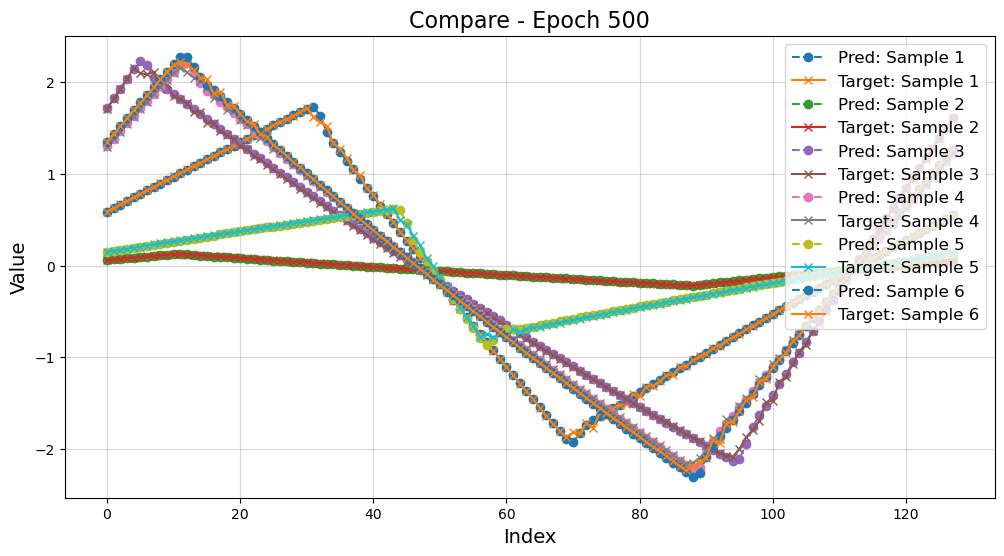

Epoch 501, Train Loss: 0.000539, Validation Loss: 0.000565
Saving model at epoch 501 with validation loss 0.000565...
Epoch 502, Train Loss: 0.000507, Validation Loss: 0.000592
Epoch 503, Train Loss: 0.000538, Validation Loss: 0.000600
Epoch 504, Train Loss: 0.000586, Validation Loss: 0.000599
Epoch 505, Train Loss: 0.000574, Validation Loss: 0.000590
Epoch 506, Train Loss: 0.000546, Validation Loss: 0.000617
Epoch 507, Train Loss: 0.000555, Validation Loss: 0.000573
Epoch 508, Train Loss: 0.000536, Validation Loss: 0.000563
Saving model at epoch 508 with validation loss 0.000563...
Epoch 509, Train Loss: 0.000528, Validation Loss: 0.000631
Epoch 510, Train Loss: 0.000555, Validation Loss: 0.000565
Epoch 511, Train Loss: 0.000550, Validation Loss: 0.000661
Epoch 512, Train Loss: 0.000588, Validation Loss: 0.000663
Epoch 513, Train Loss: 0.000576, Validation Loss: 0.000574
Epoch 514, Train Loss: 0.000576, Validation Loss: 0.000726
Epoch 515, Train Loss: 0.000595, Validation Loss: 0.0006

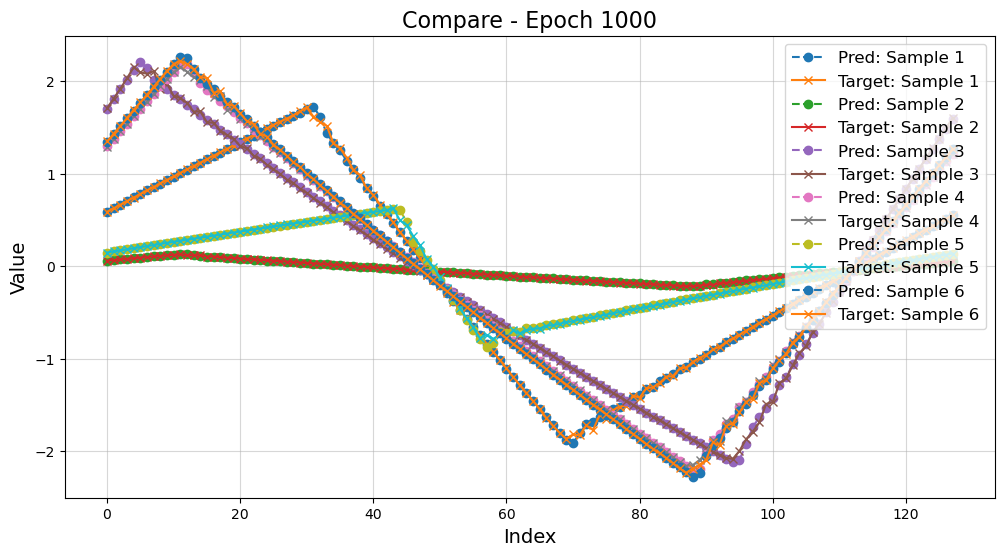

Epoch 1001, Train Loss: 0.000449, Validation Loss: 0.000484
Epoch 1002, Train Loss: 0.000483, Validation Loss: 0.000477
Epoch 1003, Train Loss: 0.000446, Validation Loss: 0.000484
Epoch 1004, Train Loss: 0.000456, Validation Loss: 0.000460
Epoch 1005, Train Loss: 0.000438, Validation Loss: 0.000458
Epoch 1006, Train Loss: 0.000444, Validation Loss: 0.000457
Epoch 1007, Train Loss: 0.000450, Validation Loss: 0.000464
Epoch 1008, Train Loss: 0.000438, Validation Loss: 0.000450
Saving model at epoch 1008 with validation loss 0.000450...
Epoch 1009, Train Loss: 0.000430, Validation Loss: 0.000464
Epoch 1010, Train Loss: 0.000461, Validation Loss: 0.000457
Epoch 1011, Train Loss: 0.000449, Validation Loss: 0.000462
Epoch 1012, Train Loss: 0.000434, Validation Loss: 0.000476
Epoch 1013, Train Loss: 0.000468, Validation Loss: 0.000453
Epoch 1014, Train Loss: 0.000453, Validation Loss: 0.000461
Epoch 1015, Train Loss: 0.000459, Validation Loss: 0.000457
Epoch 1016, Train Loss: 0.000439, Valida

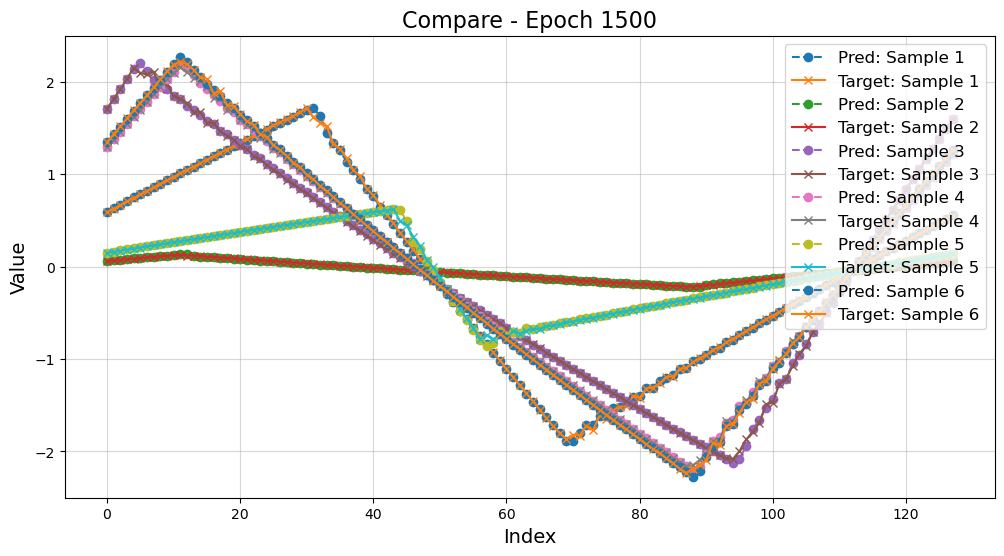

Epoch 1501, Train Loss: 0.000349, Validation Loss: 0.000399
Epoch 1502, Train Loss: 0.000380, Validation Loss: 0.000382
Epoch 1503, Train Loss: 0.000363, Validation Loss: 0.000400
Epoch 1504, Train Loss: 0.000383, Validation Loss: 0.000358
Saving model at epoch 1504 with validation loss 0.000358...
Epoch 1505, Train Loss: 0.000361, Validation Loss: 0.000366
Epoch 1506, Train Loss: 0.000364, Validation Loss: 0.000361
Epoch 1507, Train Loss: 0.000343, Validation Loss: 0.000358
Saving model at epoch 1507 with validation loss 0.000358...
Epoch 1508, Train Loss: 0.000324, Validation Loss: 0.000357
Saving model at epoch 1508 with validation loss 0.000357...
Epoch 1509, Train Loss: 0.000336, Validation Loss: 0.000365
Epoch 1510, Train Loss: 0.000357, Validation Loss: 0.000356
Saving model at epoch 1510 with validation loss 0.000356...
Epoch 1511, Train Loss: 0.000354, Validation Loss: 0.000376
Epoch 1512, Train Loss: 0.000361, Validation Loss: 0.000374
Epoch 1513, Train Loss: 0.000356, Valida

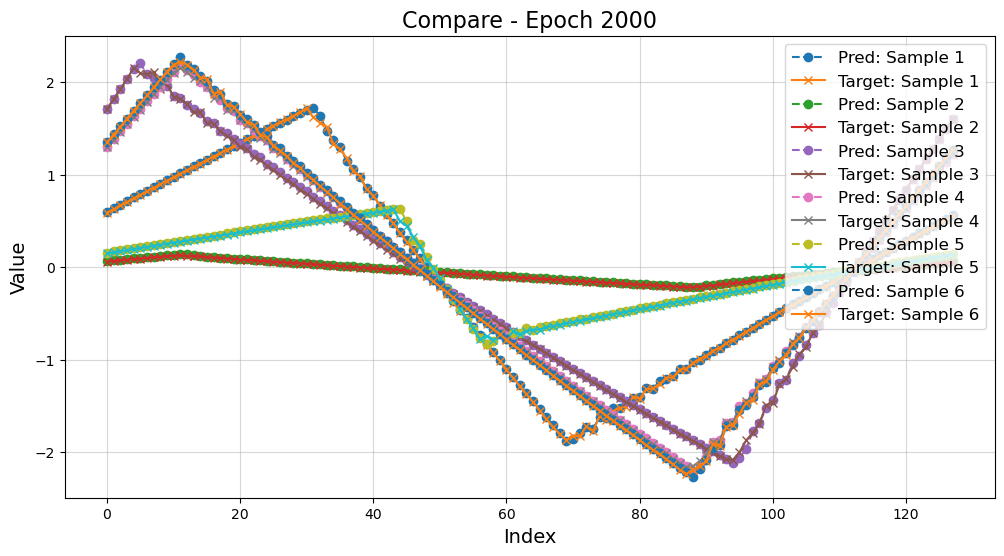

Epoch 2001, Train Loss: 0.000350, Validation Loss: 0.000356
Epoch 2002, Train Loss: 0.000320, Validation Loss: 0.000349
Epoch 2003, Train Loss: 0.000346, Validation Loss: 0.000344
Epoch 2004, Train Loss: 0.000326, Validation Loss: 0.000328
Epoch 2005, Train Loss: 0.000323, Validation Loss: 0.000335
Epoch 2006, Train Loss: 0.000331, Validation Loss: 0.000343
Epoch 2007, Train Loss: 0.000327, Validation Loss: 0.000320
Epoch 2008, Train Loss: 0.000323, Validation Loss: 0.000353
Epoch 2009, Train Loss: 0.000341, Validation Loss: 0.000345
Epoch 2010, Train Loss: 0.000321, Validation Loss: 0.000317
Epoch 2011, Train Loss: 0.000322, Validation Loss: 0.000322
Epoch 2012, Train Loss: 0.000306, Validation Loss: 0.000319
Epoch 2013, Train Loss: 0.000303, Validation Loss: 0.000321
Epoch 2014, Train Loss: 0.000313, Validation Loss: 0.000331
Epoch 2015, Train Loss: 0.000326, Validation Loss: 0.000326
Epoch 2016, Train Loss: 0.000307, Validation Loss: 0.000324
Epoch 2017, Train Loss: 0.000327, Valida

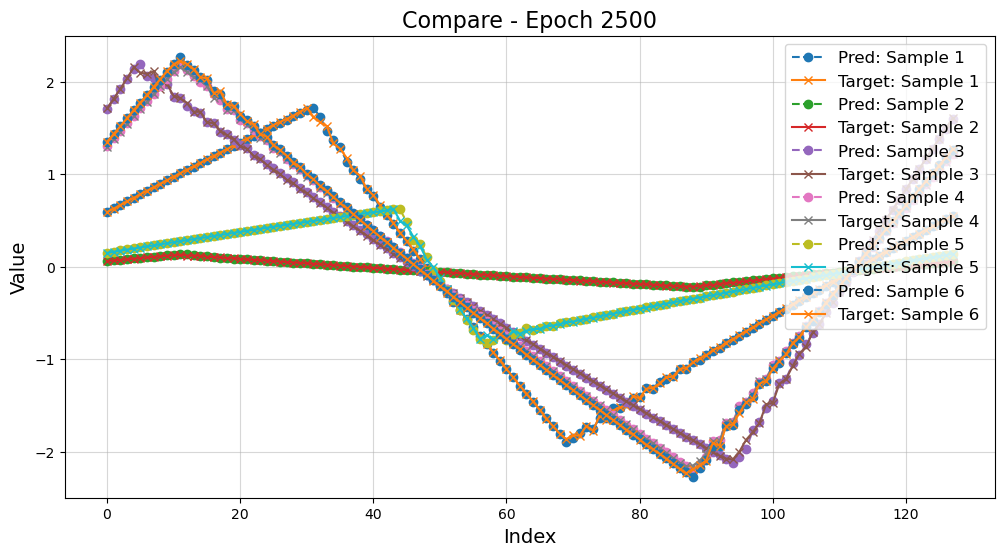

Epoch 2501, Train Loss: 0.000305, Validation Loss: 0.000294
Epoch 2502, Train Loss: 0.000307, Validation Loss: 0.000311
Epoch 2503, Train Loss: 0.000283, Validation Loss: 0.000304
Epoch 2504, Train Loss: 0.000283, Validation Loss: 0.000291
Epoch 2505, Train Loss: 0.000283, Validation Loss: 0.000289
Saving model at epoch 2505 with validation loss 0.000289...
Epoch 2506, Train Loss: 0.000301, Validation Loss: 0.000305
Epoch 2507, Train Loss: 0.000312, Validation Loss: 0.000296
Epoch 2508, Train Loss: 0.000309, Validation Loss: 0.000319
Epoch 2509, Train Loss: 0.000294, Validation Loss: 0.000320
Epoch 2510, Train Loss: 0.000326, Validation Loss: 0.000386
Epoch 2511, Train Loss: 0.000369, Validation Loss: 0.000307
Epoch 2512, Train Loss: 0.000299, Validation Loss: 0.000313
Epoch 2513, Train Loss: 0.000299, Validation Loss: 0.000301
Epoch 2514, Train Loss: 0.000305, Validation Loss: 0.000291
Epoch 2515, Train Loss: 0.000297, Validation Loss: 0.000293
Epoch 2516, Train Loss: 0.000290, Valida

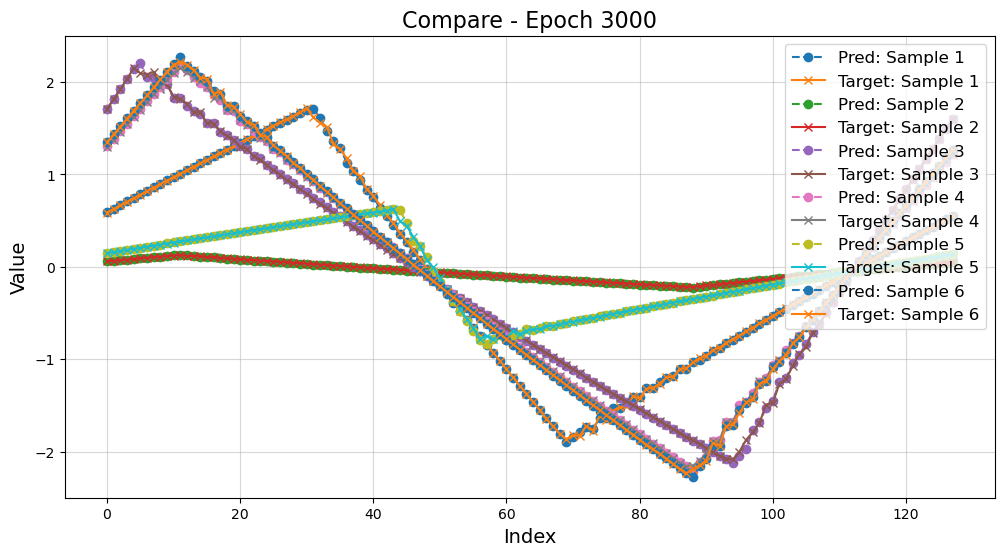

Training complete. Best model saved at ./Model/CH467160.pt.


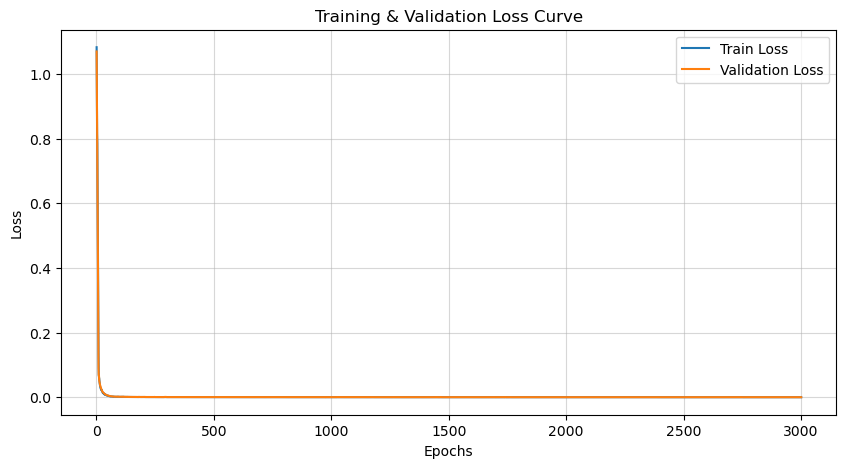

C:\Users\USER\AppData\Local\Temp\ipykernel_53976\2247312915.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))  # 載入最佳模

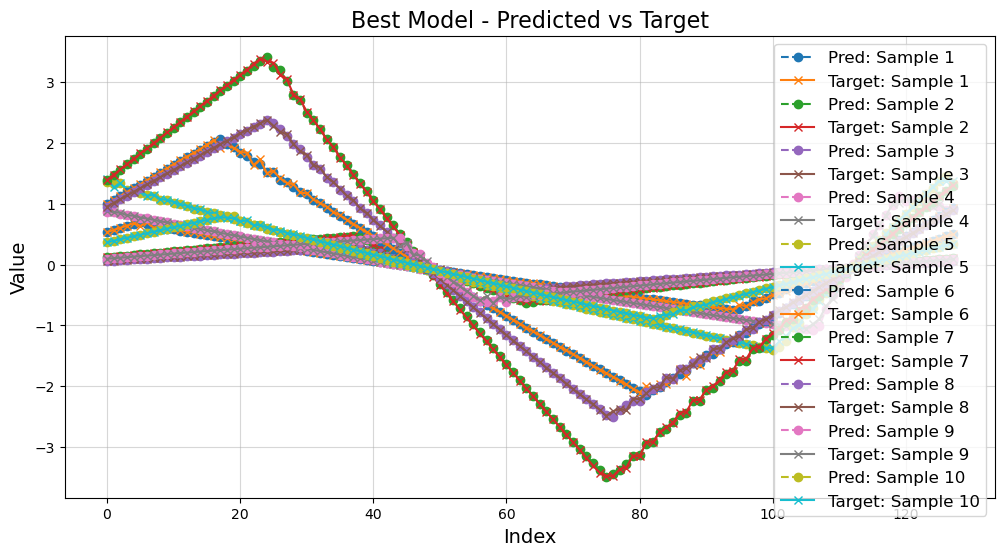

In [48]:
if __name__ == "__main__":

    data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N = load_dataset(
        material)

    train_loader, valid_loader, norm = get_dataloader(data_B, data_F, data_T,
                                                      data_H, data_N, data_Hdc,
                                                      data_Pcv)

    train_model(norm, train_loader, valid_loader)